In [1]:
import pandas as pd
import numpy as np
import json
import datetime as dt
from datetime import datetime, date, time,timedelta
import pandas as pd
from csv import DictWriter
import urllib
import re,datetime
import os
import time
from os import walk
import re
import gc
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)


#############
#INPUTS
#############

delta = 50


index = "BANKNIFTY"
index_file_path = "D:/2011-2015 BN/Banknifty/BANKNIFTY.csv"

stfolder = r"D:/2011-2015 BN/BankNiftyConstituents"
    
wgt_lot_path = "D:/Dispersion/Dispersion Data - 2021/BankNifty Weights/BN Mcap & includeok - Copy - Copy.csv"

direc = r"D:\Dispersion Backtest\Dispersion Working Files - 16.22 - Only Correlation delta 11-15/Delta_" + str(delta)

output_path = r"D:\Dispersion Backtest\Dispersion output files check - 16.22 - Only Correlation delta 11-15/Delta_" + str(delta)

index_lotsize = 1

initial_equity = 100000


#########################
#Creating Stock List
#########################

filename = next(walk(stfolder), (None, None, []))[2]  # [] if no file
stock_list_path = []
for i in filename:
    temp = stfolder +"/"+ i
    stock_list_path.append(temp)

    
stock_list = []
for i in stock_list_path:
    stock_list.append(i.replace(".csv","").replace(stfolder + "/",""))
print(stock_list)
    
######################################    
#Creating weight and lot dictionary
######################################

"""wgtlot_df = pd.read_csv(wgt_lot_path)
wgtlot_dict = wgtlot_df.set_index('Symbol').T.to_dict('list')
print(wgtlot_dict)
symbols = list(wgtlot_dict.keys())"""

### Now adding Columns for weights below

######################################

lookback_period = 15
std_dev = 2

####################
#EXPIRY DATES
####################
symbols = stock_list.copy()
symbols.append(index)

exp_file_path = "expiry_dates.csv"
exp_df = pd.read_csv(exp_file_path,parse_dates = ["curr_exp_date","Date"],dayfirst =True,usecols = ["curr_exp_date","Date","curr_exp_month_week_number"])
#exp_df.rename({'curr_date': 'Date'}, axis=1, inplace=True)

['AXISBANK', 'BANKBARODA', 'BANKINDIA', 'CANBK', 'FEDERALBNK', 'HDFCBANK', 'ICICIBANK', 'IDBI', 'INDUSINDBK', 'KOTAKBANK', 'PNB', 'SBIN', 'UNIONBANK', 'YESBANK']


### Separating Current Month, Next Month and Far Month data

In [2]:
idx = pd.read_csv(index_file_path,parse_dates = ["Date"],dayfirst = True)
df1 = idx[idx['Ticker'].str.endswith('- I')]
df2 = idx[idx['Ticker'].str.endswith('- II')]
df3 = idx[idx['Ticker'].str.endswith('- III')]



index_file_path = direc + "/BANKNIFTY.csv"

df1.to_csv(index_file_path)
df2.to_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-II"))
df3.to_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-III"))

print(idx.shape[0])
print(df1.shape[0]+df2.shape[0]+df3.shape[0])
    
for i in stock_list:
    df = pd.read_csv(stfolder + '/' + i + ".csv",parse_dates = ["Date"],dayfirst = True)
    df1 = df[df['Ticker'].str.endswith('-I')]
    df2 = df[df['Ticker'].str.endswith('-II')]
    df3 = df[df['Ticker'].str.endswith('-III')]
    
    path = direc + '/' + i + ".csv"
    
    df1.to_csv(path)
    df2.to_csv(path.replace(i,i+"-II"))
    df3.to_csv(path.replace(i,i+"-III"))
    
    print(df.shape[0])
    print(df1.shape[0]+df2.shape[0]+df3.shape[0])

stfolder = direc
print(index_file_path)

68756
68756
124659
124659
89770
89770
44105
44105
76775
76775
71103
71103
112064
112064
140524
140524
38977
38977
87793
87793
87279
87279
91862
91862
183144
183144
41946
41946
84105
84105
D:\Dispersion Backtest\Dispersion Working Files - 16.22 - Only Correlation delta 11-15/Delta_50/BANKNIFTY.csv


In [3]:
idx = pd.read_csv(index_file_path,usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close", "IV", 'Delta', f'Delta_{delta}_Strike'],parse_dates = ["Date"])

idx = pd.merge(idx, exp_df, on = 'Date', how = 'left')

idx_ce = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "CE")].add_suffix("_CE")
idx_pe = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "PE")].add_suffix("_PE")


final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])

final = final.T.drop_duplicates().T  #Drop Duplicates Columns

final = final.add_prefix(index +"_")
final = final.sort_values(by=index +"_"+'Date_CE')

final.to_csv(output_path+"/check-1data.csv")

for i in stock_list:
    print(i)
    df1 = pd.read_csv(stfolder+ '/' + i + ".csv",parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])

    df1 = pd.merge(df1, exp_df, on = 'Date', how = 'left')
    
    
    df_ce = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "CE")].add_suffix("_CE")
    df_pe = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "PE")].add_suffix("_PE")
    print(df1.shape[0], df_ce.shape[0], df_pe.shape[0])
    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Date_CE')
    
final = final.T.drop_duplicates().T
curr_final_df = final.copy()
u = curr_final_df.select_dtypes(exclude=['datetime'])
curr_final_df[u.columns] = u.fillna(0)

curr_final_df.to_csv(output_path+"/check-2data.csv")

AXISBANK
90465 2808 2808
BANKBARODA
68523 2629 2538
BANKINDIA
35234 2090 1938
CANBK
61251 2738 2648
FEDERALBNK
56155 2321 2260
HDFCBANK
80587 2808 2808
ICICIBANK
96076 2808 2808
IDBI
31415 2130 2116
INDUSINDBK
66749 2468 2406
KOTAKBANK
66878 2803 2801
PNB
67810 2797 2772
SBIN
118252 2808 2808
UNIONBANK
33878 1925 1857
YESBANK
59576 2289 2288


In [4]:
idx = pd.read_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-II"),usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"],parse_dates = ["Date"])


idx = pd.merge(idx, exp_df, on = 'Date', how = 'left')


idx_ce = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "CE")].add_suffix("_CE")
idx_pe = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "PE")].add_suffix("_PE")


final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])

final = final.T.drop_duplicates().T  #Drop Duplicates Columns

final = final.add_prefix(index +"_")
final = final.sort_values(by=index +"_"+'Date_CE')
final.to_csv(output_path+"/check-3data.csv")

for i in stock_list:
    print(i)
    path  = stfolder+ '/' + i + ".csv"
    df1 = pd.read_csv(path.replace(i,i+"-II"),parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])
    df1 = pd.merge(df1, exp_df, on = 'Date', how = 'left')

    
    df_ce = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "CE")].add_suffix("_CE")
    df_pe = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "PE")].add_suffix("_PE")
    
    
    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Date_CE')



    

final = final.T.drop_duplicates().T
next_final_df = final.copy()

next_final_df.to_csv(output_path+"/check-4.0data.csv")

u = next_final_df.select_dtypes(exclude=['datetime'])
next_final_df[u.columns] = u.fillna(0)

next_final_df.to_csv(output_path+"/check-4data.csv")

AXISBANK
BANKBARODA
BANKINDIA
CANBK
FEDERALBNK
HDFCBANK
ICICIBANK
IDBI
INDUSINDBK
KOTAKBANK
PNB
SBIN
UNIONBANK
YESBANK


In [5]:
replacedf = curr_final_df[curr_final_df[index + "_Date_CE"] == curr_final_df[index + "_curr_exp_date_CE"]]
restdf = curr_final_df[~(curr_final_df[index + "_Date_CE"] == curr_final_df[index + "_curr_exp_date_CE"])]

nextdf = next_final_df[next_final_df[index + "_Date_CE"] == next_final_df[index + "_curr_exp_date_CE"]]


for i in symbols:
    if nextdf.shape[0] == replacedf.shape[0]:
        replacedf[i + "_IV_CE"] = nextdf[i + "_IV_CE"]
        replacedf[i + "_IV_PE"] = nextdf[i + "_IV_PE"]
        replacedf[i + '_Strike_CE'] = nextdf[i + '_Strike_CE']
        if delta!=50:
            replacedf[i + '_Strike_PE'] = nextdf[i + '_Strike_PE']
        else:
            replacedf[i + '_Strike_PE'] = nextdf[i + '_Strike_CE']
        replacedf[i + '_Delta_CE'] = nextdf[i + '_Delta_CE']
        replacedf[i + '_Delta_PE'] = nextdf[i + '_Delta_PE']
        
        print("EXCHANGE DONE")
    else:
        print("Entries Missing Error")
        break

final = restdf.append(replacedf).sort_values(by=[index+"_Date_CE"]).reset_index().drop(columns = ["index"])


Entries Missing Error


In [6]:
final.to_csv(output_path+"\Part-1data.csv")
data = pd.read_csv(output_path+"\Part-1data.csv",parse_dates = [index + "_Date_CE"],dayfirst = True)


In [7]:
#Adding Avg IV Columns
data[index + "_Avg IV"] = (data[index + "_IV_CE"] + data[index + "_IV_PE"])/2
curr_final_df[index + "_Avg IV"] = data[index + "_Avg IV"]

data[index + "_Avg Delta"] = (data[index + "_Delta_CE"] + (- data[index + "_Delta_PE"]))/2
curr_final_df[index + "_Avg Delta"] = data[index + "_Avg Delta"]

for i in stock_list:
    data[i + "_Avg IV"] = (data[i + "_IV_CE"] + data[i + "_IV_PE"])/2
    curr_final_df[i + "_Avg IV"] = data[i + "_Avg IV"]
    
    data[i + "_Avg Delta"] = (data[i + "_Delta_CE"] + (- data[i + "_Delta_PE"]))/2
    curr_final_df[i + "_Avg Delta"] = data[i + "_Avg Delta"]
    
    
data = curr_final_df.copy()

# Adding Weights Columns

In [8]:
weight = pd.read_csv(wgt_lot_path,parse_dates = ["date"],dayfirst = True,usecols = ["Security Symbol","Weightage","date","includeok","Lotsize"])

In [9]:
grp = weight.groupby("Security Symbol")
data[index + "_OG_Weight"] = 100
for i in stock_list:
    d1 = grp.get_group(i)
    d1[i + "_OG_Weight"] = d1["Weightage"]
    d1[index+ "_Date_CE"] = d1["date"]
    data = pd.merge(data,d1[[index+ "_Date_CE",i + "_OG_Weight"]],on= index+ "_Date_CE", how='left')

if data.isnull().sum().sum() != 0:
    print(data.isnull().sum().sum())
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")



7094
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR


### Adding Final Weight Columns

In [10]:
filter_col = [col for col in data if col.endswith('Weight')]
filter_col.remove(index + "_OG_Weight")

data["actual_wgt_sum"] = data[filter_col].sum(axis=1)

for i in stock_list:
    data[i + "_Final_Weight"] = data[i + "_OG_Weight"]/data["actual_wgt_sum"]
data[index + "_Final_Weight"] = 1

In [11]:
u = data.select_dtypes(exclude=['datetime'])
data[u.columns] = u.fillna(0)



In [12]:
data['index_iv'] = data[index +'_Avg IV']*100
data['stock_iv']  = 0


data['index_delta'] = data[index +'_Avg Delta']*100
data['stock_delta']  = 0


for i in stock_list:
    data['stock_iv'] += data[i + '_Avg IV']*data[i + "_Final_Weight"] 
    
    data['stock_delta'] += data[i + '_Avg Delta']*data[i + "_Final_Weight"]
    
data['implied_correl'] = (data['index_iv']/data['stock_iv'])

print(data.isnull().sum().sum())

4445


In [13]:
data['avg'] = data['implied_correl'].rolling(lookback_period).mean()
df = data.copy()

df.to_csv(output_path+'/impliedratio.csv')

In [14]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * std_dev # Calculate top band
    bollinger_down = sma - std * std_dev # Calculate bottom band
    return bollinger_up, bollinger_down

df['bollinger_up'], df['bollinger_down'] = get_bollinger_bands(df['implied_correl'], lookback_period)

df['sma'] = get_sma(df['implied_correl'], lookback_period)
df['long_avg'] = df['implied_correl'].mean()


#print(df['bollinger_up'])
#print(df['bollinger_down'])
#print(df['long_avg'])
#print(df['sma'])

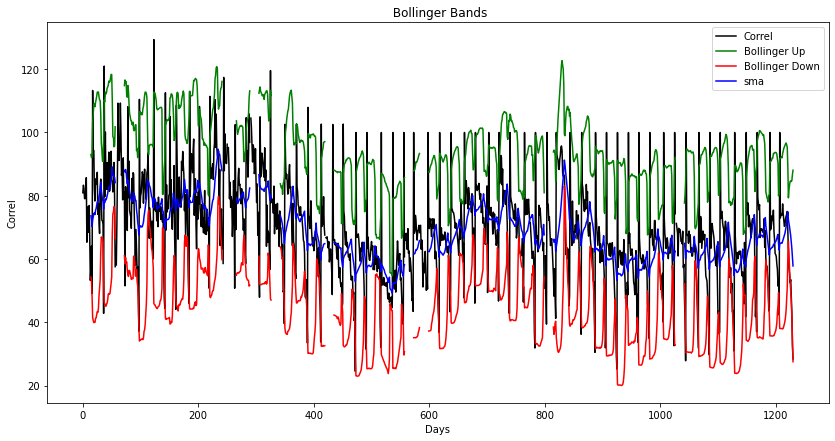

In [15]:
import matplotlib.pyplot as plt

df.head()

fig = plt.figure(figsize=(14,7))
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Correl')
plt.plot(df['implied_correl'], label='Correl', c = 'black')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='g')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='r')
plt.plot(df['sma'], label='sma', c='b')

plt.legend()
plt.show()

In [16]:
df.to_csv(output_path+"\series.csv")

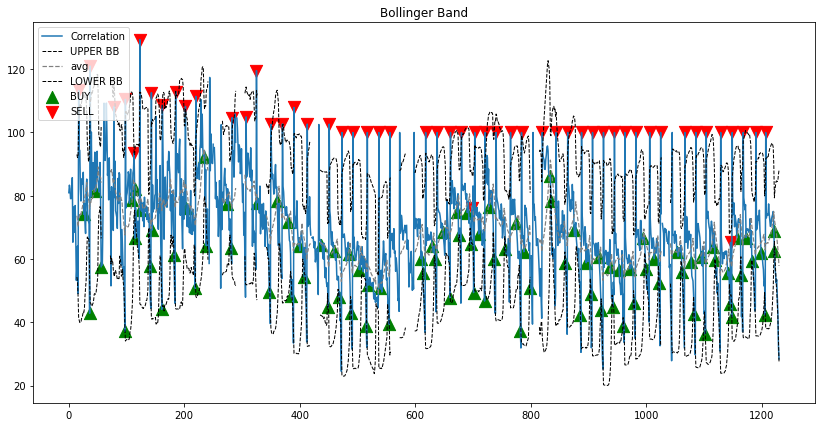

In [17]:
def implement_bb_strategy(data, lower_bb, upper_bb, avg):
    entry_ratio = []
    exit_ratio = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(i==0):
            if data[i] < lower_bb[i]:
                if signal != 1:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(0)
            elif data[i] > upper_bb[i]:
                if signal != -1:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(0)
            else:
                entry_ratio.append(np.nan)
                exit_ratio.append(np.nan)
                bb_signal.append(0)
        else:
            if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
                if signal != 1:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            elif data[i-1] > avg[i-1] and data[i] < avg[i]:
                if signal != 0:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 0
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])                
            
            elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
                if signal != -1:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            elif data[i-1] < avg[i-1] and data[i] > avg[i]:
                if signal != 0:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = 0
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            else:
                entry_ratio.append(np.nan)
                exit_ratio.append(np.nan)
                bb_signal.append(bb_signal[i-1])

    return entry_ratio, exit_ratio, bb_signal

df['entry_ratio'], df['exit_ratio'], df['bb_signal'] = implement_bb_strategy(df['implied_correl'], df['bollinger_down'], df['bollinger_up'], df['avg'])

fig = plt.figure(figsize=(14,7))


df['implied_correl'].plot(label = 'Correlation', alpha = 1)
df['bollinger_up'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df['avg'].plot(label = 'avg', linestyle = '--', linewidth = 1.2, color = 'grey')
df['bollinger_down'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, df['entry_ratio'], marker = '^', color = 'green', label = 'BUY', s = 150)
plt.scatter(df.index, df['exit_ratio'], marker = 'v', color = 'red', label = 'SELL', s = 150)
plt.title('Bollinger Band')
plt.legend(loc = 'upper left')
plt.show()


In [18]:
df1 = df.copy()

In [19]:
df1['dispersion_entry'] = False #(df1['bb_signal'] == -1) & (df1['exit_ratio'] > 0)  & (df1['entry_ratio'].isna() == True)
df1['dispersion_exit'] = False #(df1['bb_signal'] == 0) & (df1['entry_ratio'] > 0) & (df1['entry_ratio'].isna() == False)

df1['correlation_entry'] = np.nan
df1['correlation_exit'] = np.nan
df1['bb_signal'] = np.nan

#df1['correlation_entry'] = (df1['bb_signal'] == 1) & (df1['entry_ratio'] > 0)  & (df1['exit_ratio'].isna() == True)
#df1['correlation_exit'] = (df1['bb_signal'] == 0)  & (df1['exit_ratio'] > 0)  & (df1['exit_ratio'].isna() == False):

df1['bb_signal'] = df1.apply(lambda x: 0 if x['BANKNIFTY_Date_CE']==x['BANKNIFTY_curr_exp_date_CE'] else 1, axis=1)



# for i in range(len(df1)):
#     if(i==0):
#         df1.loc[i,'correlation_entry'] = True
#         df1.loc[i,'correlation_exit'] = False
#     elif (df1.loc[i-1, 'BANKNIFTY_Date_CE'] == df1.loc[i-1, 'BANKNIFTY_curr_exp_date_CE']):  
#         df1.loc[i,'correlation_entry'] = True
#         df1.loc[i,'correlation_exit'] = False
#     elif (df1.loc[i,'BANKNIFTY_Date_CE'] == df1.loc[i,'BANKNIFTY_curr_exp_date_CE']):
#         df1.loc[i,'correlation_entry'] = False
#         df1.loc[i,'correlation_exit'] = True
#     else:
#         df1.loc[i,'correlation_entry'] = False
#         df1.loc[i,'correlation_exit'] = False

for i in range(len(df1)):
    if(i==0):
        df1.loc[i,'correlation_entry'] = True
        df1.loc[i,'correlation_exit'] = False
    elif (df1.loc[i-1, 'BANKNIFTY_Date_CE'] == df1.loc[i-1, 'BANKNIFTY_curr_exp_date_CE']):  
        df1.loc[i,'correlation_entry'] = True
        df1.loc[i,'correlation_exit'] = False
    elif (df1.loc[i,'BANKNIFTY_Date_CE'] == df1.loc[i,'BANKNIFTY_curr_exp_date_CE']):
        df1.loc[i,'correlation_entry'] = False
        df1.loc[i,'correlation_exit'] = True
    else:
        df1.loc[i,'correlation_entry'] = False
        df1.loc[i,'correlation_exit'] = False
    

In [20]:
df2 = df1.copy()


df2.to_csv(output_path + '//' + 'with entry exit signals_all data.csv')

In [21]:
# getting all the rows with entry or exit signals
df = df2[ (df2["dispersion_entry"] == True) | (df2["correlation_exit"] == True) | 
              (df2["dispersion_exit"] == True) | (df2["correlation_entry"] == True) ].reset_index()

df.to_csv(output_path + '//' + 'with entry exit signals.csv')

In [22]:
trades = []

for i in df.index[:-1]:
    if df["bb_signal"][i] == -1:
        strikes = {}
        strikes[index + '_Strike_CE'] = df[index + "_Strike_CE"][i]
        strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]

#         if delta != 50: 
#             strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
#         else:
#             strikes[index + '_Strike_PE'] = df[index + "_Strike_CE"][i]
            
        for j in stock_list:
            strikes[j + '_Strike_CE'] = df[j +"_Strike_CE"][i]
            strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
#             if delta != 50: 
#                 strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
#             else:
#                 strikes[j + '_Strike_PE'] = df[j + "_Strike_CE"][i]
        trades.append( 
                        { 
                          "entry_date": df[index + "_Date_CE"][i],
                          "exit_date" : df[index + "_Date_CE"][i+1],
                          "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                          "type_of_trade": "SILS",
                          "strike" : strikes,
                          "entry_ratio" : df["exit_ratio"][i],
                          "exit_ratio" : df["entry_ratio"][i+1]
                        }
                      )
                            
    if df["bb_signal"][i] == 1:
            strikes = {}
            strikes[index + '_Strike_CE'] = df[index + "_Strike_CE"][i]
            strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
#             if delta != 50:
#                 strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
#             else:
#                 strikes[index + '_Strike_PE'] = df[index + "_Strike_CE"][i]
            for j in stock_list:
                strikes[j + '_Strike_CE'] = df[j + "_Strike_CE"][i]
                strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
#                 if delta != 50: 
#                     strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
#                 else:
#                     strikes[j + '_Strike_PE'] = df[j + "_Strike_CE"][i]
            trades.append( 
                            { 
                              "entry_date": df[index + "_Date_CE"][i],
                              "exit_date" : df[index + "_Date_CE"][i+1],
                              "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                              "type_of_trade": "LISS",
                              "strike" : strikes,
                              "entry_ratio" : df["entry_ratio"][i],
                              "exit_ratio" : df["exit_ratio"][i+1]
                            }
                          )

In [23]:
for i in tqdm(trades):
    date1 = i["entry_date"]
    date2 = i["exit_date"]
    expiry = i["expiry_date"]
    print(date1)
    print(date2)
    
    if expiry == date1:
        df = pd.read_csv(index_file_path,parse_dates = ["Date"])
        nextdf = pd.read_csv(index_file_path.replace(index,index+"-II"),parse_dates = ["Date"])
        
        df = df[(df["Date"] > date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][index + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][index + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
        nextdf = nextdf[(nextdf["Date"] == expiry) & 
                        (((nextdf["Strike"] == i["strike"][index + '_Strike_CE']) & (nextdf['Option_Type'] == 'CE')) |
                        ((nextdf['Strike'] == i['strike'][index + '_Strike_PE']) & (nextdf['Option_Type'] == 'PE')))]
        
        nextdf = nextdf.append(df)
        nextdf = pd.merge(nextdf, exp_df, on = 'Date', how = 'left')
        df_dict = {}
        df_dict[index] = nextdf
        for j in stock_list:
            path = stfolder + '/' + j + ".csv"
            df = pd.read_csv(path,parse_dates = ["Date"])
            nextdf = pd.read_csv(path.replace(j,j+"-II"),parse_dates = ["Date"])
                        
            df = df[(df["Date"] > date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][j + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][j + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]   
            
            
            nextdf = nextdf[(nextdf["Date"] == expiry) & 
                        (((nextdf["Strike"] == i["strike"][index + '_Strike_CE']) & (nextdf['Option_Type'] == 'CE')) |
                        ((nextdf['Strike'] == i['strike'][index + '_Strike_PE']) & (nextdf['Option_Type'] == 'PE')))]
            nextdf = nextdf.append(df)
            nextdf = pd.merge(nextdf, exp_df, on = 'Date', how = 'left')
            df_dict[j] = nextdf
        i["dataframes"] = df_dict
    
    else:
        df = pd.read_csv(index_file_path,parse_dates = ["Date"])
        df = df[(df["Date"] >= date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][index + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][index + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
        df = pd.merge(df, exp_df, on = 'Date', how = 'left')
        df_dict = {}
        df_dict[index] = df
        
        for j in stock_list:
            df = pd.read_csv(stfolder + '/' + j + ".csv",parse_dates = ["Date"])    
            df = df[(df["Date"] >= date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][j + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][j + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
                
            df = pd.merge(df, exp_df, on = 'Date', how = 'left')
            df_dict[j] = df
        i["dataframes"] = df_dict

  0%|          | 0/59 [00:00<?, ?it/s]

2011-01-03 00:00:00
2011-01-27 00:00:00
2011-01-28 00:00:00
2011-02-24 00:00:00
2011-02-25 00:00:00
2011-03-31 00:00:00
2011-04-01 00:00:00
2011-04-28 00:00:00
2011-04-29 00:00:00
2011-05-26 00:00:00
2011-05-27 00:00:00
2011-06-30 00:00:00
2011-07-01 00:00:00
2011-07-28 00:00:00
2011-07-29 00:00:00
2011-08-25 00:00:00
2011-08-26 00:00:00
2011-09-29 00:00:00
2011-09-30 00:00:00
2011-10-25 00:00:00
2011-10-28 00:00:00
2011-11-24 00:00:00
2011-11-25 00:00:00
2011-12-29 00:00:00
2011-12-30 00:00:00
2012-01-25 00:00:00
2012-01-27 00:00:00
2012-02-23 00:00:00
2012-02-24 00:00:00
2012-03-29 00:00:00
2012-03-30 00:00:00
2012-04-26 00:00:00
2012-04-27 00:00:00
2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-28 00:00:00
2012-06-29 00:00:00
2012-07-26 00:00:00
2012-07-27 00:00:00
2012-08-30 00:00:00
2012-08-31 00:00:00
2012-09-27 00:00:00
2012-09-28 00:00:00
2012-10-25 00:00:00
2012-10-26 00:00:00
2012-11-29 00:00:00
2012-11-30 00:00:00
2012-12-27 00:00:00
2012-12-28 00:00:00
2013-01-31 00:00:00


In [24]:
# check what does trades[i]['dataframes'] contains
for i in trades:
    print(i["dataframes"]['BANKNIFTY'].columns)

Index(['Unnamed: 0', 'Date', 'Ticker',
       'OPT_Open', 'OPT_High', 'OPT_Low',
       'OPT_Close', 'OPT_Contracts', 'OPT_OI',
       'Strike', 'Option_Type', 'Expiry_Date',
       'IV', 'Delta', 'Theta', 'Gamma', 'Vega',
       'EQ_Open', 'EQ_High', 'EQ_Low',
       'EQ_Close', 'At_The_Money',
       'Delta_5_Strike', 'Delta_10_Strike',
       'Delta_15_Strike', 'Delta_20_Strike',
       'Delta_25_Strike', 'Delta_30_Strike',
       'Delta_35_Strike', 'Delta_40_Strike',
       'Delta_45_Strike', 'Delta_50_Strike',
       'curr_exp_date',
       'curr_exp_month_week_number'],
      dtype='object')
Index(['Unnamed: 0', 'Date', 'Ticker',
       'OPT_Open', 'OPT_High', 'OPT_Low',
       'OPT_Close', 'OPT_Contracts', 'OPT_OI',
       'Strike', 'Option_Type', 'Expiry_Date',
       'IV', 'Delta', 'Theta', 'Gamma', 'Vega',
       'EQ_Open', 'EQ_High', 'EQ_Low',
       'EQ_Close', 'At_The_Money',
       'Delta_5_Strike', 'Delta_10_Strike',
       'Delta_15_Strike', 'Delta_20_Strike',
       'D

In [25]:
result = pd.DataFrame()
for trade_dict in trades:
    
    # df_dict contains options details for all the stocks and index for all the dates between entry and exit date
    df_dict = trade_dict["dataframes"]
    entry = trade_dict["entry_date"]
    exit = trade_dict["exit_date"]
    
    idx = df_dict[index][["Date","Ticker","OPT_Close","Strike","Option_Type","IV", 'Delta',"EQ_Close","curr_exp_date"]]
    
    idx_ce = idx[(idx["Option_Type"] == "CE")].add_suffix("_CE")
    idx_pe = idx[(idx["Option_Type"] == "PE")].add_suffix("_PE")
    
    
    
    final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    final = final.add_prefix(index +"_")

    for i in df_dict:
        if i == index:
            continue
        df1 = df_dict[i][["Date","Ticker","OPT_Close","Strike","Option_Type","IV", 'Delta', "EQ_Close","curr_exp_date"]]
        df_ce = df1[(df1["Option_Type"] == "CE")].add_suffix("_CE")
        df_pe = df1[(df1["Option_Type"] == "PE")].add_suffix("_PE")
        temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE',how='outer').drop(columns = ["Option_Type_PE","Option_Type_CE"])
        temp['Date_CE'] = np.where(temp['Date_CE'].isnull(), temp['Date_PE'],temp['Date_CE'])
        temp = temp.T.drop_duplicates().T
        temp = temp.add_prefix(i +"_")
        
        final = final.merge(temp,left_on=index + '_Date_CE' , right_on= i + '_Date_CE', how = 'left')
    final["Trade_Type"] = trade_dict["type_of_trade"]
    
    final.to_csv(output_path + '//' + 'final.csv', index=False)

    conditions = [
    (final[index + '_Date_CE'] == entry),
    (final[index + '_Date_CE'] == exit),
    (final[index + '_Date_CE'] != exit) & (final[index + '_Date_CE'] != entry)]

    # create a list of the values we want to assign for each condition
    values = ['F', 'L', 'M']

    # create a new column and use np.select to assign values to it using our lists as arguments
    final['D_marker'] = np.select(conditions, values)
    result = result.append(final)
        
result = result.T.drop_duplicates().T
result.to_csv(output_path + '//' + 'final1.csv', index=False)
display(result)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Date_PE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,...,UNIONBANK_Delta_PE,UNIONBANK_EQ_Close_PE,UNIONBANK_curr_exp_date_PE,YESBANK_Date_CE,YESBANK_Ticker_CE,YESBANK_OPT_Close_CE,YESBANK_Strike_CE,YESBANK_IV_CE,YESBANK_Delta_CE,YESBANK_EQ_Close_CE,YESBANK_curr_exp_date_CE,YESBANK_Date_PE,YESBANK_Ticker_PE,YESBANK_OPT_Close_PE,YESBANK_Strike_PE,YESBANK_IV_PE,YESBANK_Delta_PE,YESBANK_EQ_Close_PE,YESBANK_curr_exp_date_PE,Trade_Type,D_marker,SBIN_Date_PE,SBIN_Strike_PE,SBIN_EQ_Close_PE,SBIN_curr_exp_date_PE
0,2011-01-03,BANKNIFTY11800CE - I,291.45,11800,0.210366,0.555463,11833.75,2011-01-27,BANKNIFTY11800PE - I,217.95,0.209451,-0.443401,2011-01-03,AXISBANK270CE-I,10.95,270,0.308938,0.596213,273.53,2011-01-27,2011-01-03,AXISBANK270PE-I,6.58,270.0,0.310473,...,NaN,NaN,NaT,2011-01-03,YESBANK64CE-I,1.95,64,0.350728,0.469968,63.11,2011-01-27,2011-01-03,YESBANK64PE-I,2.43,64.0,0.319734,-0.535213,63.11,2011-01-27,LISS,F,NaT,NaN,NaN,NaT
1,2011-01-04,BANKNIFTY11800CE - I,189.0,11800,0.240188,0.395677,11556.4004,2011-01-27,BANKNIFTY11800PE - I,290.0,0.143151,-0.681904,2011-01-04,AXISBANK270CE-I,8.02,270,0.289426,0.52294,269.59,2011-01-27,2011-01-04,AXISBANK270PE-I,8.0,270.0,0.30499,...,NaN,NaN,NaT,2011-01-04,YESBANK64CE-I,1.4,64,0.39207,0.359684,61.29,2011-01-27,2011-01-04,YESBANK64PE-I,3.46,64.0,0.312839,-0.680741,61.29,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
2,2011-01-05,BANKNIFTY11800CE - I,110.0,11800,0.249677,0.268118,11306.0498,2011-01-27,BANKNIFTY11800PE - I,540.0,0.218081,-0.762202,2011-01-05,AXISBANK270CE-I,5.31,270,0.321183,0.383621,262.18,2011-01-27,2011-01-05,AXISBANK270PE-I,12.12,270.0,0.313392,...,NaN,NaN,NaT,2011-01-05,YESBANK64CE-I,0.75,64,0.44394,0.217498,58.26,2011-01-27,2011-01-05,YESBANK64PE-I,5.99,64.0,0.366664,-0.832072,58.26,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
3,2011-01-06,BANKNIFTY11800CE - I,76.0,11800,0.253911,0.204626,11169.0498,2011-01-27,BANKNIFTY11800PE - I,592.6,0.000005,-0.999137,2011-01-06,AXISBANK270CE-I,4.8,270,0.323644,0.361941,261.17,2011-01-27,2011-01-06,AXISBANK270PE-I,12.1,270.0,0.291524,...,NaN,NaN,NaT,2011-01-06,YESBANK64CE-I,0.48,64,0.464072,0.153547,56.61,2011-01-27,2011-01-06,YESBANK64PE-I,7.29,64.0,0.302825,-0.945844,56.61,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
4,2011-01-07,BANKNIFTY11800CE - I,49.0,11800,0.259709,0.145995,11017.4502,2011-01-27,BANKNIFTY11800PE - I,696.75,0.000005,-0.999178,2011-01-07,AXISBANK270CE-I,3.6,270,0.351748,0.285443,256.13,2011-01-27,2011-01-07,AXISBANK270PE-I,14.14,270.0,0.208592,...,NaN,NaN,NaT,2011-01-07,YESBANK64CE-I,0.34,64,0.545774,0.1079,54.05,2011-01-27,2011-01-07,YESBANK64PE-I,9.62,64.0,0.000005,-0.999178,54.05,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,2015-11-19,BANKNIFTY17300CE - I,85.25,17300,0.18497,0.308468,17057.9004,2015-11-26,BANKNIFTY17300PE - I,309.25,0.183215,-0.693014,2015-11-19,AXISBANK480CE-I,2.3,480,0.306411,0.210801,463.05,2015-11-26,NaT,AXISBANK480PE-I,17.1,NaN,0.197673,...,-0.202741,161.3,2015-11-26,2015-11-19,YESBANK152CE-I,0.76,152,0.310054,0.215886,146.68,2015-11-26,NaT,YESBANK152PE-I,5.22,NaN,0.142694,-0.959183,NaN,NaT,LISS,M,NaT,NaN,NaN,NaT
14,2015-11-20,BANKNIFTY17300CE - I,55.25,17300,0.163131,0.25932,17050.3496,2015-11-26,BANKNIFTY17300PE - I,303.7,0.181203,-0.718413,2015-11-20,AXISBANK480CE-I,1.1,480,0.287976,0.131158,459.85,2015-11-26,NaT,AXISBANK480PE-I,20.4,NaN,0.248208,...,-0.23869,161.95,2015-11-26,2015-11-20,

In [26]:
data = result.copy()

eq11 = pd.DataFrame()
eq11['Date'] = data['BANKNIFTY_Date_CE']
print(type(data.iloc[0]['BANKNIFTY_Date_CE']))

for i in stock_list:
    eq_file = pd.read_csv("D:/All data/final updated equity data"+'//'+i+'.csv', parse_dates = ['Date'], dayfirst = True, usecols = ['Date', 'Close']).drop_duplicates()
    print(eq_file)
    eq_file.to_csv(output_path+'//'+'eqcheck.csv')
    
    eq_file = eq_file.rename(columns = {'Close':i+'_EQ_Close'})
    eq11 = eq11.merge(eq_file, how='left',on='Date')
    eq11.to_csv(output_path+'//'+'eqcheck11.csv')
    eq11.reset_index(drop=True, inplace=True)
    data[i+"_EQ_Close_CE"] = eq11[i+'_EQ_Close']
    data.to_csv(output_path+'//'+'eqcheckdata.csv')
    

display(eq11)
display(data)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
           Date   Close
0    2009-02-02   79.57
1    2009-02-03   79.10
2    2009-02-04   79.03
3    2009-02-05   78.46
4    2009-02-06   80.60
...         ...     ...
3346 2022-08-04  721.60
3347 2022-08-05  728.50
3348 2022-08-08  745.55
3349 2022-08-10  739.00
3350 2022-08-11  758.85

[3351 rows x 2 columns]
           Date   Close
0    2009-02-02   49.32
1    2009-02-03   48.83
2    2009-02-04   49.21
3    2009-02-05   49.14
4    2009-02-06   49.43
...         ...     ...
3347 2022-08-04  118.60
3348 2022-08-05  117.90
3349 2022-08-08  118.25
3350 2022-08-10  118.65
3351 2022-08-11  123.20

[3352 rows x 2 columns]
           Date   Close
0    2009-02-02  239.00
1    2009-02-03  238.55
2    2009-02-04  241.30
3    2009-02-05  238.80
4    2009-02-06  244.70
...         ...     ...
3346 2022-08-04   48.75
3347 2022-08-05   48.75
3348 2022-08-08   48.65
3349 2022-08-10   48.30
3350 2022-08-11   49.10

[3351 rows x 2 columns]
          

,Date,AXISBANK_EQ_Close,BANKBARODA_EQ_Close,BANKINDIA_EQ_Close,CANBK_EQ_Close,FEDERALBNK_EQ_Close,HDFCBANK_EQ_Close,ICICIBANK_EQ_Close,IDBI_EQ_Close,INDUSINDBK_EQ_Close,KOTAKBANK_EQ_Close,PNB_EQ_Close,SBIN_EQ_Close,UNIONBANK_EQ_Close,YESBANK_EQ_Close
0,2011-01-03,273.53,178.46,451.10,662.35,40.42,239.05,228.97,166.05,264.65,228.55,244.55,282.21,341.50,63.11
1,2011-01-04,269.59,175.61,438.55,649.25,39.35,234.56,220.81,162.75,255.75,230.25,244.15,273.56,331.85,61.29
2,2011-01-05,262.18,175.07,439.50,620.05,38.14,230.82,213.87,157.95,249.05,224.45,241.10,269.32,324.25,58.26
3,2011-01-06,261.17,167.71,443.15,623.20,37.50,232.77,210.69,156.75,243.90,222.55,238.23,262.24,320.10,56.61
4,2011-01-07,256.13,169.78,450.10,606.75,37.37,226.94,209.84,152.55,230.25,217.60,233.74,260.10,321.15,54.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-11-19,463.05,168.10,128.90,269.30,56.95,534.45,266.40,84.45,914.15,682.10,139.15,243.90,161.30,146.68
1193,2015-11-20,459.85,171.90,129.60,268.70,56.40,535.42,264.95,84.45,921.85,682.30,139.50,242.95,161.95,146.24
1194,2015-11-23,462.70,169.35,128.35,268.25,56.95,533.03,265.95,83.75,919.70,684.10,138.80,242.70,160.50,148.13
1195,2015-11-24,463.85,168.20,124.60,263.75,56.90,532.17,263.35,82.00,919.55,677.60,138.00,241.40,158.80,148.83


,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Date_PE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,...,UNIONBANK_Delta_PE,UNIONBANK_EQ_Close_PE,UNIONBANK_curr_exp_date_PE,YESBANK_Date_CE,YESBANK_Ticker_CE,YESBANK_OPT_Close_CE,YESBANK_Strike_CE,YESBANK_IV_CE,YESBANK_Delta_CE,YESBANK_EQ_Close_CE,YESBANK_curr_exp_date_CE,YESBANK_Date_PE,YESBANK_Ticker_PE,YESBANK_OPT_Close_PE,YESBANK_Strike_PE,YESBANK_IV_PE,YESBANK_Delta_PE,YESBANK_EQ_Close_PE,YESBANK_curr_exp_date_PE,Trade_Type,D_marker,SBIN_Date_PE,SBIN_Strike_PE,SBIN_EQ_Close_PE,SBIN_curr_exp_date_PE
0,2011-01-03,BANKNIFTY11800CE - I,291.45,11800,0.210366,0.555463,11833.75,2011-01-27,BANKNIFTY11800PE - I,217.95,0.209451,-0.443401,2011-01-03,AXISBANK270CE-I,10.95,270,0.308938,0.596213,273.53,2011-01-27,2011-01-03,AXISBANK270PE-I,6.58,270.0,0.310473,...,NaN,NaN,NaT,2011-01-03,YESBANK64CE-I,1.95,64,0.350728,0.469968,63.11,2011-01-27,2011-01-03,YESBANK64PE-I,2.43,64.0,0.319734,-0.535213,63.11,2011-01-27,LISS,F,NaT,NaN,NaN,NaT
1,2011-01-04,BANKNIFTY11800CE - I,189.0,11800,0.240188,0.395677,11556.4004,2011-01-27,BANKNIFTY11800PE - I,290.0,0.143151,-0.681904,2011-01-04,AXISBANK270CE-I,8.02,270,0.289426,0.52294,269.59,2011-01-27,2011-01-04,AXISBANK270PE-I,8.0,270.0,0.30499,...,NaN,NaN,NaT,2011-01-04,YESBANK64CE-I,1.4,64,0.39207,0.359684,61.29,2011-01-27,2011-01-04,YESBANK64PE-I,3.46,64.0,0.312839,-0.680741,61.29,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
2,2011-01-05,BANKNIFTY11800CE - I,110.0,11800,0.249677,0.268118,11306.0498,2011-01-27,BANKNIFTY11800PE - I,540.0,0.218081,-0.762202,2011-01-05,AXISBANK270CE-I,5.31,270,0.321183,0.383621,262.18,2011-01-27,2011-01-05,AXISBANK270PE-I,12.12,270.0,0.313392,...,NaN,NaN,NaT,2011-01-05,YESBANK64CE-I,0.75,64,0.44394,0.217498,58.26,2011-01-27,2011-01-05,YESBANK64PE-I,5.99,64.0,0.366664,-0.832072,58.26,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
3,2011-01-06,BANKNIFTY11800CE - I,76.0,11800,0.253911,0.204626,11169.0498,2011-01-27,BANKNIFTY11800PE - I,592.6,0.000005,-0.999137,2011-01-06,AXISBANK270CE-I,4.8,270,0.323644,0.361941,261.17,2011-01-27,2011-01-06,AXISBANK270PE-I,12.1,270.0,0.291524,...,NaN,NaN,NaT,2011-01-06,YESBANK64CE-I,0.48,64,0.464072,0.153547,56.61,2011-01-27,2011-01-06,YESBANK64PE-I,7.29,64.0,0.302825,-0.945844,56.61,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
4,2011-01-07,BANKNIFTY11800CE - I,49.0,11800,0.259709,0.145995,11017.4502,2011-01-27,BANKNIFTY11800PE - I,696.75,0.000005,-0.999178,2011-01-07,AXISBANK270CE-I,3.6,270,0.351748,0.285443,256.13,2011-01-27,2011-01-07,AXISBANK270PE-I,14.14,270.0,0.208592,...,NaN,NaN,NaT,2011-01-07,YESBANK64CE-I,0.34,64,0.545774,0.1079,54.05,2011-01-27,2011-01-07,YESBANK64PE-I,9.62,64.0,0.000005,-0.999178,54.05,2011-01-27,LISS,M,NaT,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,2015-11-19,BANKNIFTY17300CE - I,85.25,17300,0.18497,0.308468,17057.9004,2015-11-26,BANKNIFTY17300PE - I,309.25,0.183215,-0.693014,2015-11-19,AXISBANK480CE-I,2.3,480,0.306411,0.210801,250.70,2015-11-26,NaT,AXISBANK480PE-I,17.1,NaN,0.197673,...,-0.202741,161.3,2015-11-26,2015-11-19,YESBANK152CE-I,0.76,152,0.310054,0.215886,51.70,2015-11-26,NaT,YESBANK152PE-I,5.22,NaN,0.142694,-0.959183,NaN,NaT,LISS,M,NaT,NaN,NaN,NaT
14,2015-11-20,BANKNIFTY17300CE - I,55.25,17300,0.163131,0.25932,17050.3496,2015-11-26,BANKNIFTY17300PE - I,303.7,0.181203,-0.718413,2015-11-20,AXISBANK480CE-I,1.1,480,0.287976,0.131158,248.44,2015-11-26,NaT,AXISBANK480PE-I,20.4,NaN,0.248208,...,-0.23869,161.95,2015-11-26,2015-11-20,Y

In [27]:
data =pd.read_csv(output_path+'//'+'eqcheckdata.csv',parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
for i in stock_list:
    data[i+'_OPT_Close_CE'] = data[i+'_OPT_Close_CE'].ffill()
    data[i+'_OPT_Close_PE'] = data[i+'_OPT_Close_PE'].ffill()

data.to_csv(output_path+'//'+'optcheckdata.csv')    

for i,j in data.iterrows():
    for k in stock_list:
        if(data.loc[i,'D_marker'] == 'L'):
            if(data.loc[i,k+'_Strike_CE'] >= data.loc[i,k+'_EQ_Close_CE']):
                data.loc[i,k+'_OPT_Close_CE'] = 0
            else:
                data.loc[i,k+'_OPT_Close_CE'] = data.loc[i,k+'_EQ_Close_CE'] - data.loc[i,k+'_Strike_CE']
                
            if(data.loc[i,k+'_Strike_PE'] <= data.loc[i,k+'_EQ_Close_CE']):
                data.loc[i,k+'_OPT_Close_PE'] = 0
            else:
                data.loc[i,k+'_OPT_Close_PE'] = data.loc[i,k+'_Strike_PE'] - data.loc[i,k+'_EQ_Close_CE']
    
data.to_csv(output_path + '//' + 'before_weigt_add_second_time.csv')

### Adding Weight and Lot Columns Again

In [28]:
weight = pd.read_csv(wgt_lot_path,parse_dates = ["date"],dayfirst = True,usecols = ["Security Symbol","Weightage","date","Lotsize"])

In [29]:


grp = weight.groupby("Security Symbol")
data[index + "_OG_Weight"] = 100
data[index + "_Lotsize"] = index_lotsize
for i in stock_list:
    d1 = grp.get_group(i)
    d1[i + "_OG_Weight"] = d1["Weightage"]
    d1[i + "_Lotsize"] = d1["Lotsize"]
    d1[index+ "_Date_CE"] = d1["date"]
    data = pd.merge(data,d1[[index+ "_Date_CE",i + "_OG_Weight",i+ "_Lotsize"]],on= index+ "_Date_CE", how='left')

if data.isnull().sum().sum() != 0:
    print(data.isnull().sum().sum())
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")

u = data.select_dtypes(exclude=['datetime'])
data[u.columns] = u.fillna(0)

for i,c in data.iterrows():
    for j in stock_list:
        if((data.loc[i,'D_marker'] == "F") & ((data.loc[i,j+'_Ticker_CE'] == 0) | (data.loc[i,j+'_Ticker_PE'] == 0))):
            
            data.loc[i,j+'_OG_Weight'] = 0
        

data.to_csv(output_path + '//' + 'weigt_add_second_time.csv')

87823
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR


### Adding Final Weight Columns

In [30]:
filter_col = [col for col in data if col.endswith('Weight')]
filter_col.remove(index + "_OG_Weight")

data["actual_wgt_sum"] = data[filter_col].sum(axis=1)
for i in stock_list:
    data[i + "_Final_Weight"] = data[i + "_OG_Weight"]/data["actual_wgt_sum"]
data[index + "_Final_Weight"] = 1

In [31]:
filter_col = [col for col in data if col.endswith('Final_Weight')]
filter_col.remove(index + "_Final_Weight")

data[filter_col] = data[filter_col].replace(0,np.nan)
data["Min_Share_Value"] = data[filter_col].min(axis = 1)
data["Min_Share_Name"] = data[filter_col].idxmin(axis=1)
print(data["Min_Share_Value"])
print(data["Min_Share_Name"])

data[filter_col] = data[filter_col].replace(np.nan,0)

0       0.028847
1       0.024600
2       0.024395
3       0.024500
4       0.024102
          ...   
1192    0.009500
1193    0.009399
1194    0.009500
1195    0.009501
1196    0.009401
Name: Min_Share_Value, Length: 1197, dtype: float64
0             IDBI_Final_Weight
1             IDBI_Final_Weight
2             IDBI_Final_Weight
3             IDBI_Final_Weight
4             IDBI_Final_Weight
                 ...           
1192    FEDERALBNK_Final_Weight
1193    FEDERALBNK_Final_Weight
1194    FEDERALBNK_Final_Weight
1195    FEDERALBNK_Final_Weight
1196    FEDERALBNK_Final_Weight
Name: Min_Share_Name, Length: 1197, dtype: object


In [32]:
display(data)
data.to_csv(output_path + '//' + 'before_qty_add.csv')
display(data['Min_Share_Name'].info())

,Unnamed: 0,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Date_PE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,...,PNB_Lotsize,SBIN_OG_Weight,SBIN_Lotsize,UNIONBANK_OG_Weight,UNIONBANK_Lotsize,YESBANK_OG_Weight,YESBANK_Lotsize,actual_wgt_sum,AXISBANK_Final_Weight,BANKBARODA_Final_Weight,BANKINDIA_Final_Weight,CANBK_Final_Weight,FEDERALBNK_Final_Weight,HDFCBANK_Final_Weight,ICICIBANK_Final_Weight,IDBI_Final_Weight,INDUSINDBK_Final_Weight,KOTAKBANK_Final_Weight,PNB_Final_Weight,SBIN_Final_Weight,UNIONBANK_Final_Weight,YESBANK_Final_Weight,BANKNIFTY_Final_Weight,Min_Share_Value,Min_Share_Name
0,0,2011-01-03,BANKNIFTY11800CE - I,291.45,11800,0.210366,0.555463,11833.7500,2011-01-27,BANKNIFTY11800PE - I,217.9500,0.209451,-0.443401,2011-01-03,AXISBANK270CE-I,10.95,270.0,0.308938,0.596213,273.53,2011-01-27,2011-01-03,AXISBANK270PE-I,6.58,270.0,...,1.0,26.86,1.0,0.00,1.0,0.00,0.0,84.93,0.098905,0.000000,0.000000,0.000000,0.000000,0.195926,0.232662,0.028847,0.000000,0.059343,0.068056,0.316260,0.000000,0.000000,1,0.028847,IDBI_Final_Weight
1,1,2011-01-04,BANKNIFTY11800CE - I,189.00,11800,0.240188,0.395677,11556.4004,2011-01-27,BANKNIFTY11800PE - I,290.0000,0.143151,-0.681904,2011-01-04,AXISBANK270CE-I,8.02,270.0,0.289426,0.522940,269.59,2011-01-27,2011-01-04,AXISBANK270PE-I,8.00,270.0,...,1.0,26.65,1.0,2.57,1.0,0.00,0.0,100.00,0.084800,0.049100,0.035300,0.040800,0.000000,0.167100,0.195000,0.024600,0.000000,0.052000,0.059100,0.266500,0.025700,0.000000,1,0.024600,IDBI_Final_Weight
2,2,2011-01-05,BANKNIFTY11800CE - I,110.00,11800,0.249677,0.268118,11306.0498,2011-01-27,BANKNIFTY11800PE - I,540.0000,0.218081,-0.762202,2011-01-05,AXISBANK270CE-I,5.31,270.0,0.321183,0.383621,262.18,2011-01-27,2011-01-05,AXISBANK270PE-I,12.12,270.0,...,1.0,26.79,1.0,2.57,1.0,0.00,0.0,100.02,0.084183,0.049890,0.036193,0.039792,0.000000,0.167866,0.192861,0.024395,0.000000,0.051790,0.059488,0.267846,0.025695,0.000000,1,0.024395,IDBI_Final_Weight
3,3,2011-01-06,BANKNIFTY11800CE - I,76.00,11800,0.253911,0.204626,11169.0498,2011-01-27,BANKNIFTY11800PE - I,592.6000,0.000005,-0.999137,2011-01-06,AXISBANK270CE-I,4.80,270.0,0.323644,0.361941,261.17,2011-01-27,2011-01-06,AXISBANK270PE-I,12.10,270.0,...,1.0,26.40,1.0,2.56,1.0,0.00,0.0,100.00,0.084900,0.048400,0.036900,0.040500,0.000000,0.171400,0.192300,0.024500,0.000000,0.052000,0.059500,0.264000,0.025600,0.000000,1,0.024500,IDBI_Final_Weight
4,4,2011-01-07,BANKNIFTY11800CE - I,49.00,11800,0.259709,0.145995,11017.4502,2011-01-27,BANKNIFTY11800PE - I,696.7500,0.000005,-0.999178,2011-01-07,AXISBANK270CE-I,3.60,270.0,0.351748,0.285443,256.13,2011-01-27,2011-01-07,AXISBANK270PE-I,14.14,270.0,...,1.0,26.49,1.0,2.60,1.0,0.00,0.0,99.99,0.084208,0.049605,0.037904,0.039904,0.000000,0.169017,0.193819,0.024102,0.000000,0.051405,0.059106,0.264926,0.026003,0.000000,1,0.024102,IDBI_Final_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,13,2015-11-19,BANKNIFTY17300CE - I,85.25,17300,0.184970,0.308468,17057.9004,2015-11-26,BANKNIFTY17300PE - I,309.2500,0.183215,-0.693014,2015-11-19,AXISBANK480CE-I,2.30,480.0,0.306411,0.210801,250.70,2015-11-26,0,AXISBANK480PE-I,17.10,0.0,...,1.0,18.31,1.0,0.00,0.0,2.97,1.0,100.00,0.106500,0.037500,0.009900,0.014100,0.009500,0.260500,0.149600,0.000000,0.052400,0.120800,0.026400,0.183100,0.000000,0.029700,1,0.009500,FEDERALBNK_Final_Weight
1193,14,2015-11-20,BANKNIFTY17300CE - I,55.25,17300,0.163131,0.259320,17050.3496,2015-11-26,BANKNIFTY17300PE - I,303.7000,0.181203

<class 'pandas.core.series.Series'>
Int64Index: 1197 entries, 0 to 1196
Series name: Min_Share_Name
Non-Null Count  Dtype 
--------------  ----- 
1197 non-null   object
dtypes: object(1)
memory usage: 51.0+ KB


None

In [33]:
#ADDING QTYS
data = pd.read_csv(output_path + "/before_qty_add.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

result = data.copy()
min_exp = []
for idi, row in result.iterrows():
    min_share_stock = row['Min_Share_Name'].replace("_Final_Weight","")
#     print(min_share_stock)
    value  = row[min_share_stock + "_EQ_Close_CE"]*row[min_share_stock + "_Lotsize"]
    min_exp.append(value)
    
result["MinExp"] = min_exp
result[index + "_exp"] = (result["MinExp"]/result["Min_Share_Value"])
#result[index + "_lot"] = (result[index + "_exp"]/(result[index + "_Lotsize"]*result[index + "_EQ_Close_CE"])).astype(int)
result[index + "_lot"] = (result[index + "_exp"]/(result[index + "_Lotsize"]*result[index + "_EQ_Close_CE"]))
result[index + "_qty"] = result[index + "_lot"]*result[index + "_Lotsize"]

result.to_csv(output_path + '//' + 'resultt.csv')

#for stocks with includeok=0, making '_Lotsize' & '_EQ_Close_CE' non-zero

filter_col_Lotsize = [col for col in result if col.endswith('_Lotsize')]
filter_col_Lotsize.remove(index + "_Lotsize")
result[filter_col_Lotsize] = result[filter_col_Lotsize].replace(0,1)


filter_col_EQ_Close = [col for col in result if col.endswith('_EQ_Close_CE')]
filter_col_EQ_Close.remove(index + "_EQ_Close_CE")
result[filter_col_EQ_Close] = result[filter_col_EQ_Close].replace(0,1)

result['index_exp'] = result[index + "_exp"]

result.to_csv(output_path + '//' + 'resulttcheckcheck.csv')

result['stock_exp'] = 0

for idi, row in result.iterrows():
    min_share_stock = result.loc[idi,'Min_Share_Name'].replace("_Final_Weight","")
    #print(min_share_stock)
    
    for i in stock_list:

        if(i==min_share_stock):
    #         print('xxxxxx',i)
    #         result[index + "_exp"]
    #         result[i + "_Final_Weight"]
            result.loc[idi,i + "_exp"] = result.loc[idi,"MinExp"]
            result.loc[idi,i  + "_lot"] = 1
            result.loc[idi,i + "_qty"] = result.loc[idi,i + "_lot"]*result.loc[idi,i + "_Lotsize"]

            result.loc[idi,'stock_exp'] += result.loc[idi,i + "_exp"]

        else:
    #         result[index + "_exp"]
    #         result[i + "_Final_Weight"]
            result.loc[idi,i + "_exp"] = (result.loc[idi,index + "_exp"]*result.loc[idi,i + "_Final_Weight"])
    #         result[i  + "_lot"] = (result[i + "_exp"]/(result[i + "_Lotsize"]*result[i+ "_EQ_Close_CE"])).astype(int)
            result.loc[idi,i  + "_lot"] = (result.loc[idi,i + "_exp"]/(result.loc[idi,i + "_Lotsize"]*result.loc[idi,i+ "_EQ_Close_CE"]))
            result.loc[idi,i + "_qty"] = result.loc[idi,i + "_lot"]*result.loc[idi,i + "_Lotsize"]

            result.loc[idi,'stock_exp'] += result.loc[idi,i + "_exp"]


In [34]:
result['total_exposure'] = (result['index_exp'] + result['stock_exp']) * 2

conditions = [
    (result["Trade_Type"] == "LISS"),
    (result["Trade_Type"] == "SILS")]

values = [result['total_exposure']/10,result['total_exposure']/10]
result['margin'] = np.select(conditions, values)

result['units'] = (initial_equity/result['margin'])

result.to_csv(output_path+"/final2.csv")

In [35]:
conditions = [
    (result["D_marker"] == "F"),
    (result["D_marker"] != "F")]

values = [result[index + "_qty"]*result['units'],np.nan]
result[index + '_qty_final'] = np.select(conditions, values)

for i in stock_list:
    values = [result[i + "_qty"]*result['units'],np.nan]
    result[i + '_qty_final'] = np.select(conditions, values)

In [36]:
result = result.ffill()

In [37]:
display(result)

result.to_csv(output_path + "/final3.csv")

,Unnamed: 0.1,Unnamed: 0,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Date_PE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,...,SBIN_qty,UNIONBANK_exp,UNIONBANK_lot,UNIONBANK_qty,YESBANK_exp,YESBANK_lot,YESBANK_qty,total_exposure,margin,units,BANKNIFTY_qty_final,AXISBANK_qty_final,BANKBARODA_qty_final,BANKINDIA_qty_final,CANBK_qty_final,FEDERALBNK_qty_final,HDFCBANK_qty_final,ICICIBANK_qty_final,IDBI_qty_final,INDUSINDBK_qty_final,KOTAKBANK_qty_final,PNB_qty_final,SBIN_qty_final,UNIONBANK_qty_final,YESBANK_qty_final
0,0,0,2011-01-03,BANKNIFTY11800CE - I,291.45,11800,0.210366,0.555463,11833.7500,2011-01-27,BANKNIFTY11800PE - I,217.9500,0.209451,-0.443401,2011-01-03,AXISBANK270CE-I,10.95,270.0,0.308938,0.596213,273.53,2011-01-27,2011-01-03,AXISBANK270PE-I,6.58,...,6.450693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23024.696327,2302.469633,43.431626,21.126017,90.396831,0.000000,0.000000,0.000000,0.000000,204.900708,254.031306,43.431626,0.000000,64.912479,69.572732,280.164106,0.0,0.000000
1,1,1,2011-01-04,BANKNIFTY11800CE - I,189.00,11800,0.240188,0.395677,11556.4004,2011-01-27,BANKNIFTY11800PE - I,290.0000,0.143151,-0.681904,2011-01-04,AXISBANK270CE-I,8.02,270.0,0.289426,0.522940,269.59,2011-01-27,2011-01-04,AXISBANK270PE-I,8.00,...,6.445113,170.027439,0.512362,0.512362,0.000000,0.000000,0.000000,26463.414634,2646.341463,37.788018,21.126017,90.396831,0.000000,0.000000,0.000000,0.000000,204.900708,254.031306,43.431626,0.000000,64.912479,69.572732,280.164106,0.0,0.000000
2,2,2,2011-01-05,BANKNIFTY11800CE - I,110.00,11800,0.249677,0.268118,11306.0498,2011-01-27,BANKNIFTY11800PE - I,540.0000,0.218081,-0.762202,2011-01-05,AXISBANK270CE-I,5.31,270.0,0.321183,0.383621,262.18,2011-01-27,2011-01-05,AXISBANK270PE-I,12.12,...,6.439230,166.365369,0.513077,0.513077,0.000000,0.000000,0.000000,25898.621311,2589.862131,38.612094,21.126017,90.396831,0.000000,0.000000,0.000000,0.000000,204.900708,254.031306,43.431626,0.000000,64.912479,69.572732,280.164106,0.0,0.000000
3,3,3,2011-01-06,BANKNIFTY11800CE - I,76.00,11800,0.253911,0.204626,11169.0498,2011-01-27,BANKNIFTY11800PE - I,592.6000,0.000005,-0.999137,2011-01-06,AXISBANK270CE-I,4.80,270.0,0.323644,0.361941,261.17,2011-01-27,2011-01-06,AXISBANK270PE-I,12.10,...,6.440899,163.787755,0.511677,0.511677,0.000000,0.000000,0.000000,25591.836735,2559.183673,39.074960,21.126017,90.396831,0.000000,0.000000,0.000000,0.000000,204.900708,254.031306,43.431626,0.000000,64.912479,69.572732,280.164106,0.0,0.000000
4,4,4,2011-01-07,BANKNIFTY11800CE - I,49.00,11800,0.259709,0.145995,11017.4502,2011-01-27,BANKNIFTY11800PE - I,696.7500,0.000005,-0.999178,2011-01-07,AXISBANK270CE-I,3.60,270.0,0.351748,0.285443,256.13,2011-01-27,2011-01-07,AXISBANK270PE-I,14.14,...,6.446690,164.576763,0.512461,0.512461,0.000000,0.000000,0.000000,25316.970124,2531.697012,39.499197,21.126017,90.396831,0.000000,0.000000,0.000000,0.000000,204.900708,254.031306,43.431626,0.000000,64.912479,69.572732,280.164106,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1192,13,2015-11-19,BANKNIFTY17300CE - I,85.25,17300,0.184970,0.308468,17057.9004,2015-11-26,BANKNIFTY17300PE - I,309.2500,0.183215,-0.693014,2015-11-19,AXISBANK480CE-I,2.30,480.0,0.306411,0.210801,250.70,2015-11-26,0,AXISBANK480PE-I,17.10,...,2.562125,0.000000,0.000000,0.000000,108.889579,2.106181,2.106181,14665.263158,1466.526316,68.188343,14.418280,98.983658,49.590945,5.542008,5.435193,55.047006,277.766158,168.253483,0.000000,48.932552,131.91861

In [38]:
display(curr_final_df)
display(next_final_df)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_curr_exp_month_week_number_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_curr_exp_month_week_number_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,...,BANKBARODA_Avg Delta,BANKINDIA_Avg IV,BANKINDIA_Avg Delta,CANBK_Avg IV,CANBK_Avg Delta,FEDERALBNK_Avg IV,FEDERALBNK_Avg Delta,HDFCBANK_Avg IV,HDFCBANK_Avg Delta,ICICIBANK_Avg IV,ICICIBANK_Avg Delta,IDBI_Avg IV,IDBI_Avg Delta,INDUSINDBK_Avg IV,INDUSINDBK_Avg Delta,KOTAKBANK_Avg IV,KOTAKBANK_Avg Delta,PNB_Avg IV,PNB_Avg Delta,SBIN_Avg IV,SBIN_Avg Delta,UNIONBANK_Avg IV,UNIONBANK_Avg Delta,YESBANK_Avg IV,YESBANK_Avg Delta
0,2011-01-03,BANKNIFTY11800CE - I,291.45,11800,0.210366,0.555463,11833.7500,2011-01-27,1.0,BANKNIFTY11800PE - I,217.95,11800,0.209451,-0.443401,2011-01-03,AXISBANK270CE-I,10.95,270,0.308938,0.596213,273.53,2011-01-27,1.0,AXISBANK270PE-I,6.58,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.237150,0.435688,0.341539,0.675058,0.382867,0.505695,0.000000,0.000000,0.325837,0.502474,0.339904,0.316872,0.301151,0.499206,0.000000,0.000000,0.335231,0.502590
1,2011-01-04,BANKNIFTY11600CE - I,279.95,11600,0.245147,0.507807,11556.4004,2011-01-27,1.0,BANKNIFTY11600PE - I,267.95,11600,0.228620,-0.492362,2011-01-04,AXISBANK270CE-I,8.02,270,0.289426,0.522940,269.59,2011-01-27,1.0,AXISBANK270PE-I,8.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.237160,0.499135,0.452127,0.713661,0.390468,0.497557,0.000000,0.000000,0.313926,0.499695,0.310845,0.396316,0.326190,0.501089,0.000000,0.000000,0.391717,0.495671
2,2011-01-05,BANKNIFTY11300CE - I,320.00,11300,0.271297,0.534017,11306.0498,2011-01-27,1.0,BANKNIFTY11300PE - I,259.95,11300,0.253119,-0.464446,2011-01-05,AXISBANK260CE-I,10.10,260,0.334811,0.570650,262.18,2011-01-27,1.0,AXISBANK260PE-I,6.79,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256276,0.499826,0.554523,0.383601,0.397267,0.502804,0.000000,0.000000,0.352550,0.490288,0.355949,0.500195,0.343866,0.500502,0.000000,0.000000,0.378580,0.513356
3,2011-01-06,BANKNIFTY11200CE - I,286.00,11200,0.267310,0.513025,11169.0498,2011-01-27,1.0,BANKNIFTY11200PE - I,253.95,11200,0.238433,-0.487410,2011-01-06,AXISBANK260CE-I,9.67,260,0.348945,0.551187,261.17,2011-01-27,1.0,AXISBANK260PE-I,6.80,...,0.000000,0.356016,0.592816,0.000000,0.000000,0.000000,0.000000,0.256720,0.499975,0.483375,0.717401,0.408573,0.496869,0.000000,0.000000,0.349975,0.496711,0.339055,0.496021,0.353484,0.497821,0.000000,0.000000,0.433598,0.498687
4,2011-01-07,BANKNIFTY11000CE - I,292.00,11000,0.260882,0.539922,11017.4502,2011-01-27,2.0,BANKNIFTY11000PE - I,250.00,11000,0.266271,-0.459576,2011-01-07,AXISBANK260CE-I,6.70,260,0.340323,0.454235,256.13,2011-01-27,2.0,AXISBANK260PE-I,10.06,...,0.000000,0.416727,0.490177,0.000000,0.000000,0.000000,0.000000,0.293121,0.496397,0.549397,0.577664,0.375552,0.508488,0.567746,0.433438,0.227399,0.727525,0.356665,0.496589,0.336161,0.499588,0.000000,0.000000,0.489559,0.498907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,2015-12-23,BANKNIFTY16900CE - I,118.00,16900,0.106997,0.535528,16903.3496,2015-12-31,4.0,BANKNIFTY16900PE - I,162.00,16900,0.173163,-0.474609,2015-12-23,AXISBANK450CE-I,6.25,450,0.184255,0.585461,452.00,2015-12-31,4.0,AXISBANK450PE-I,4.50,...,0.503961,0.328870,0.484309,0.285530,0.499239,0.274129,0.293955,0.123901,0.491693,0.703049,0.269147,0.360684,0.499856,0.173936,0.499703,0.175681,0.520071,0.280066,0.501977,0.215664,0.500132,0.275168,0.526068,0.221524,0.50229

,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_Delta_50_Strike_CE,BANKNIFTY_Date_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_curr_exp_month_week_number_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_Delta_50_Strike_PE,BANKNIFTY_Date_PE,BANKNIFTY_curr_exp_date_PE,BANKNIFTY_curr_exp_month_week_number_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,...,UNIONBANK_Strike_CE,UNIONBANK_IV_CE,UNIONBANK_Delta_CE,UNIONBANK_EQ_Close_CE,UNIONBANK_curr_exp_date_CE,UNIONBANK_curr_exp_month_week_number_CE,UNIONBANK_Ticker_PE,UNIONBANK_OPT_Close_PE,UNIONBANK_Strike_PE,UNIONBANK_IV_PE,UNIONBANK_Delta_PE,YESBANK_Date_CE,YESBANK_Ticker_CE,YESBANK_OPT_Close_CE,YESBANK_Strike_CE,YESBANK_IV_CE,YESBANK_Delta_CE,YESBANK_EQ_Close_CE,YESBANK_curr_exp_date_CE,YESBANK_curr_exp_month_week_number_CE,YESBANK_Ticker_PE,YESBANK_OPT_Close_PE,YESBANK_Strike_PE,YESBANK_IV_PE,YESBANK_Delta_PE


In [39]:
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
plvalue = []
pl = 0

for idi, row in result.iterrows():
    pval = 0
    if row["D_marker"] == "F":

        result.loc[idi, 'pl_check'] = pl + initial_equity
        result.loc[idi+1:, 'pl_check'] = np.nan

        result.loc[idi , 'units_new'] = ((result.loc[idi ,'pl_check'])/result.loc[idi, 'margin'])
        result.loc[idi+1: , 'units_new'] = np.nan
       
        result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
        result.loc[idi+1:, index + '_qty_final'] = np.nan
       
        result.loc[idi, 'plvalue_' + index] = 0

        for i in stock_list:                                                                    
            result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, i + '_qty_final'] = np.nan
            result.loc[idi, 'plvalue_' + i] = 0
       
        result = result.ffill()

       
    else:
            if row["Trade_Type"] == "SILS":
                plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
                pval = plvalce + plvalpe

                result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe
               
                for i in stock_list:
                    plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] - result.loc[idi-1, i + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_PE"] - result.loc[idi-1, i + "_OPT_Close_PE"])
                    pval += plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe
                   
            if row["Trade_Type"] == "LISS":
                plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_OPT_Close_PE"])
                pval = plvalce + plvalpe

                result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe
               
                for i in stock_list:
                    plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_CE"] - result.loc[idi, i + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_PE"] - result.loc[idi, i + "_OPT_Close_PE"])
                    pval += plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe
           
            pl += pval
       
       
    plvalue.append(pval)

result["Daily_PL"] = plvalue

result.to_csv(output_path+"\pl_final4.csv")


In [40]:
result.loc[0,'Daily_PL'] = initial_equity
result["PortfolioValue"] = (result["Daily_PL"]).cumsum()
result.loc[0,'Daily_PL'] = 0

#display(result)
result.to_csv(output_path+"/final4.1.csv")

In [41]:
result = pd.read_csv(output_path+"/final4.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
df = result.copy()
from pyxirr import xirr

firstValue = int(df.loc[0, 'PortfolioValue'])
lastValue = int(df.loc[df.index[-1], 'PortfolioValue'])

firstDate = (df.loc[0, 'BANKNIFTY_Date_CE'])
lastDate = (df.loc[df.index[-1], 'BANKNIFTY_Date_CE'])

dates = [firstDate, lastDate]
amounts = [-firstValue, lastValue]


xirr = xirr(dates, amounts)

print("xirr : ", xirr*100)
### Calculate Daily Drawdown

Roll_Max = round(df['PortfolioValue'].expanding().max(), 2)
Daily_Drawdown = (round(df['PortfolioValue'], 2)/Roll_Max) - 1.0



df['Daily_Drawdown'] = Daily_Drawdown * 100

print("max dd : ", min(df['Daily_Drawdown']))

df.to_csv(output_path + '/DailyDrawdown.csv', index=False)

### Monthly PNL Percentage 

df['BANKNIFTY_curr_exp_date_CE'] = pd.to_datetime(df['BANKNIFTY_curr_exp_date_CE'], dayfirst=True)

df['Year'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).year
df['Month'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).month
df.to_csv(output_path + '/df.csv', index=False)

i = 0
dfg = df.groupby(['Year', 'Month'])
for name, group in dfg:
    #print(name)
    if i == 0: 
        firstValue = group['PortfolioValue'].iloc[0]
        i = 1
    else:
        firstValue = lastValue

    lastValue = group['PortfolioValue'].loc[group.index[-1]]
    change = lastValue/firstValue - 1
    df.loc[group.index, 'Change_%_Monthly'] = round(change * 100, 2)

i = 0
dfg = df.groupby(['Year'])
for name, group in dfg:
    #print(name)
    if i == 0: 
        firstValue = group['PortfolioValue'].iloc[0]
        i = 1
    else:
        firstValue = lastValue

    lastValue = group['PortfolioValue'].loc[group.index[-1]]
    change = lastValue/firstValue - 1
    df.loc[group.index, 'Change_%_Yearly'] = change * 100

df

df1 = df[['Year', 'Month', 'Change_%_Monthly', 'Change_%_Yearly']]
df1 = df1.drop_duplicates()
df1

pivotTable = df1.pivot_table(values ='Change_%_Monthly', index =['Year', 'Change_%_Yearly'],
                         columns =['Month'])
pivotTable.columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                      'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

pivotTable.index

def _color_red_or_green(val):
    color = '#EE0000' if val < 0 else '#00EE00'
    return 'background-color: %s' % color
pivotTable.style.applymap(_color_red_or_green)


InvalidPaymentsError: negative and positive payments are required

# Adjustments Starts Here

In [ ]:
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)


result1 = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

result1["Date"] = result1["BANKNIFTY_Date_CE"]

final = pd.DataFrame()
final[index + '_Date_CE'] = result1["Date"]
for i in stock_list:
    print(i)
    path  = stfolder+ '/' + i + ".csv"
    df1 = pd.read_csv(path,parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close",f'Delta_{delta}_Strike','EQ_Close'], dayfirst = True)

    df_ce = df1[(df1["Strike"] == df1[f'Delta_{delta}_Strike']) & (df1["Option_Type"] == "CE")].add_suffix("_CE").add_prefix("Current_")
    df_pe = df1[(df1["Strike"] == df1[f'Delta_{delta}_Strike']) & (df1["Option_Type"] == "PE")].add_suffix("_PE").add_prefix("Current_")
    
    temp = df_ce.merge(df_pe, left_on='Current_Date_CE', right_on='Current_Date_PE').drop(columns = ["Current_Option_Type_PE","Current_Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Current_Date_CE').drop(columns = [i + "_Current_Date_CE"])
final = final.T.drop_duplicates().T

result1 = result1.merge(final, how = "left", on = index+'_Date_CE')
result1.to_csv(output_path+"/final3.1.csv")
display(result1)


# Trigger Adjustment

In [ ]:
trigger = [100, 125, 150, 175, 200]
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)



for t in trigger:
    print("trigger :", t)

    print("Generating trigger Signals.....")
    print("          ", datetime.datetime.now())
    result1 = pd.read_csv(output_path + "/final3.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
#     To add for 50 delta stoploss optimizations
#     for i in stock_list:
#         result1[i + '_Current_Strike_PE'] = result1[i + '_Current_Strike_CE']

    for idi, row in result1.iterrows():
        if row["D_marker"] == "F":

            result1.loc[idi, index + 'total_premium'] = result1.loc[idi, index + '_OPT_Close_CE'] + result1.loc[idi, index + "_OPT_Close_PE"]

            for i in stock_list:
                result1.loc[idi, i + "D_marker_1"] = "F"
                result1.loc[idi+1:, i + 'D_marker_1'] = "M"
                result1.loc[idi, i + "D_marker_2"] = "F"
                result1.loc[idi+1:, i + "D_marker_2"] = "M"


                result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                result1.loc[idi, i + 'stop_trigger_CE'] = (result1.loc[idi, i + '_Current_Strike_CE']) + (t*(result1.loc[idi, i + 'total_premium'])/100)
                result1.loc[idi, i + 'stop_trigger_PE'] = (result1.loc[idi, i + '_Current_Strike_PE']) - (t*(result1.loc[idi, i + 'total_premium'])/100)
                result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

            result1 = result1.ffill()



        else:
            for i in stock_list:

                if result1.loc[idi, "D_marker"] == "L":
                    result1.loc[idi, i + "D_marker_1"] = "L"
                    result1.loc[idi, i + "D_marker_2"] = "L"

                else:

                    if result1.loc[idi, i + 'stop_trigger_CE'] <= result1.loc[idi, i + '_Current_EQ_Close_CE']:
                        result1.loc[idi, i + "D_marker_1"] = "L"
                        result1.loc[idi, i + "D_marker_2"] = "F"

                        result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                        result1.loc[idi, i + 'stop_trigger_CE'] = (result1.loc[idi, i + '_Current_Strike_CE']) + (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi, i + 'stop_trigger_PE'] = (result1.loc[idi, i + '_Current_Strike_PE']) - (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                        result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan


                    if result1.loc[idi, i + 'stop_trigger_PE'] >= result1.loc[idi, i + '_Current_EQ_Close_CE']:
                        result1.loc[idi, i + "D_marker_1"] = "L"
                        result1.loc[idi, i + "D_marker_2"] = "F"

                        result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                        result1.loc[idi, i + 'stop_trigger_CE'] = (result1.loc[idi, i + '_Current_Strike_CE']) + (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi, i + 'stop_trigger_PE'] = (result1.loc[idi, i + '_Current_Strike_PE']) - (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                        result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

                    result1 = result1.ffill()


    #display(result1)      

    result1.to_csv(output_path + "/final3.2__" + str(t) + ".csv")


    #######################################################################################################################


    print("Generating TradeList.....")
    print("          ", datetime.datetime.now())

    trades = []
    for j in stock_list:
        df = result1[(result1[j + "D_marker_1"] == "F") | (result1[j + "D_marker_1"] == "L")].reset_index()
        #display(df)

        for i in df.index[:-1]:
            if df[j + "D_marker_2"][i] == "F":
                strikes_ce = {}
                strikes_ce[j] = df[j+"_Current_Strike_CE"][i]
                strikes_pe = {}
                strikes_pe[j] = df[j+"_Current_Strike_PE"][i]
                trades.append( 
                                { 
                                  "symbol" : j,
                                  j + "_entry_date": df[index + "_Date_CE"][i],
                                  j + "_exit_date" : df[index + "_Date_CE"][i+1],
                                  "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                                  "new_month_date" : df[index+"_curr_exp_date_CE"][i+1],
                                  "strike_ce" : strikes_ce,
                                  "strike_pe" : strikes_pe,  
                                  "marker_1" : df[j + "D_marker_1"][i],
                                  "marker_2" : df[j + "D_marker_2"][i],

                                }
                              )


    #######################################################################################################################


    df_dum = pd.DataFrame()

    df_dum['Date'] = result1['BANKNIFTY_Date_CE']

    for j in stock_list:
        print(j)
        path = direc + '/' + j + ".csv"
        for i in trades:
            symbol = i["symbol"]
            if j == symbol:
                #print("####################",j)
                date1 = i[j + "_entry_date"]
                date2 = i[j + "_exit_date"]
                expiry = i["expiry_date"]
                new_month_date = i["new_month_date"]
                marker_1 = i["marker_1"]
                marker_2 = i["marker_2"]
    #             print(date1)
    #             print(date2)
    #             print(i["strike_ce"][j])
    #             print(i["strike_pe"][j])

                if ((marker_1 == "F") & (marker_2 == "F")):       #new trade data from same row
                    df_dict = {}

                    df = pd.read_csv(path,parse_dates = ["Date"], dayfirst = True, usecols = ["Date","Ticker","Option_Type","Strike",
                                                                        "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])

                    df_ce = df[(df["Date"] >= date1) & (df["Date"] <= date2) & (df["Option_Type"] == "CE") & (df["Strike"] == i["strike_ce"][j])].add_suffix("_CE")
                    df_pe = df[(df["Date"] >= date1) & (df["Date"] <= date2) & (df["Option_Type"] == "PE") & (df["Strike"] == i["strike_pe"][j])].add_suffix("_PE")
                    df = pd.merge(df_ce, df_pe, left_on = 'Date_CE',right_on = 'Date_PE', how = 'left').reset_index()
                    df['Date'] = df['Date_CE']
                    df = pd.merge(df_dum, df, on = 'Date', how = 'left').reset_index()
                    df_dict[j] = df
                    i["dataframes"] = df_dict

                elif (marker_1 == "L") & (marker_2 == "F"):     #new trade data from next row

                    df_dict = {}

                    df = pd.read_csv(path,parse_dates = ["Date"], dayfirst = True, usecols = ["Date","Ticker","Option_Type","Strike",
                                                                        "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])

                    df_ce = df[(df["Date"] > date1) & (df["Date"] <= date2) & (df["Option_Type"] == "CE") & (df["Strike"] == i["strike_ce"][j])].add_suffix("_CE")
                    df_pe = df[(df["Date"] > date1) & (df["Date"] <= date2) & (df["Option_Type"] == "PE") & (df["Strike"] == i["strike_pe"][j])].add_suffix("_PE")
                    df = pd.merge(df_ce, df_pe, left_on = 'Date_CE',right_on = 'Date_PE', how = 'left').reset_index()
                    df['Date'] = df['Date_CE']
                    df = pd.merge(df_dum, df, on = 'Date', how = 'left').reset_index()

                    df_dict[j] = df
                    i["dataframes"] = df_dict



    #######################################################################################################################





    result1 = pd.DataFrame()
    result1[index + "_Date_CE"] = result[index + "_Date_CE"]

    for j in stock_list:
        print("j", j)
        final = pd.DataFrame()

        for trade_dict in trades:
            df_dict = trade_dict["dataframes"]
            for i in df_dict:
                    if (i != j):
                        continue

                    df_ce = df_dict[i][["Date_CE","Ticker_CE","OPT_Close_CE","Strike_CE","Option_Type_CE","IV_CE","EQ_Close_CE"]]
                    df_pe = df_dict[i][["Date_CE","Ticker_PE","OPT_Close_PE","Strike_PE","Option_Type_PE","IV_PE"]]
                    df_ce = df_ce.dropna()
                    df_pe = df_pe.dropna()

                    temp = pd.merge(df_ce,df_pe, on='Date_CE', how='left').drop(columns = ["Option_Type_PE","Option_Type_CE"])
                    temp = temp.T.drop_duplicates().T
                    temp['Date_CE'] = pd.to_datetime(temp['Date_CE'], dayfirst = True)
                    temp = temp.add_prefix(i +"_new_")
                    final = final.append(temp)

        result1 = result1.merge(final,left_on=index + '_Date_CE' , right_on= j + '_new_Date_CE', how = 'left')

    result1 = result1.T.drop_duplicates().T    
    result1.to_csv(output_path + "/final3.3__" + str(t) + ".csv")
    #display(result1)    



    #######################################################################################################################



    result1 = pd.read_csv(output_path + "/final3.2__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    result2 = pd.read_csv(output_path + "/final3.3__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)


    result = result1.merge(result2,how='left',on=index+'_Date_CE')

    #result.to_csv(output_path + "/final4.csv")
    #display(result)




    #######################################################################################################################
    print("Calculating PnL.....")
    print("          ", datetime.datetime.now())

    #result = pd.read_csv(output_path + "/final4.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

    u = result.select_dtypes(exclude=['datetime'])
    result[u.columns] = u.fillna(0)


    plvalue = []
    pl = 0
    transaction_cost = 0

    for idi, row in result.iterrows():
        pval = 0
        if row["D_marker"] == "F":
                        
            
            result.loc[idi, 'pl_check'] = pl + initial_equity
            result.loc[idi+1:, 'pl_check'] = np.nan

            result.loc[idi , 'units_new'] = ((result.loc[idi ,'pl_check'])/result.loc[idi, 'margin'])
            result.loc[idi+1: , 'units_new'] = np.nan

            result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, index + '_qty_final'] = np.nan

            result.loc[idi, 'plvalue_' + index] = 0
            
            contract_value = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] + result.loc[idi, index + "_OPT_Close_PE"])
            
            
            for i in stock_list:                                                                    
                result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
                result.loc[idi+1:, i + '_qty_final'] = np.nan
                result.loc[idi, 'plvalue_' + i] = 0
                contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] + result.loc[idi, i + "_OPT_Close_PE"])

            result.loc[idi, 'transaction_cost'] = 0
            result = result.ffill()
        

        else:

                if row["Trade_Type"] == "SILS":
                    plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
                    pval = plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

                    for i in stock_list:

                        if result.loc[idi-1,i+"D_marker_2"] == "F":

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] - result.loc[idi-1, i + "_Current_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_PE"] - result.loc[idi-1, i + "_Current_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

                        else:

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] - result.loc[idi-1, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_PE"] - result.loc[idi-1, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe
                            
                        if ((result.loc[idi, i+"D_marker_1"] == "L") & (result.loc[idi, i+"D_marker_2"] == "F")):
                            
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] + result.loc[idi, i + "_new_OPT_Close_PE"])
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_Current_OPT_Close_CE"] + result.loc[idi, i + "_Current_OPT_Close_PE"])
                            
                if row["Trade_Type"] == "LISS":
                    plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_OPT_Close_PE"])
                    pval = plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

                    for i in stock_list:
                        if result.loc[idi-1,i+"D_marker_2"] == "F":
                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Current_OPT_Close_CE"] - result.loc[idi, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Current_OPT_Close_PE"] - result.loc[idi, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

                        else:

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_new_OPT_Close_CE"] - result.loc[idi, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_new_OPT_Close_PE"] - result.loc[idi, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 
                        
                        if ((result.loc[idi, i+"D_marker_1"] == "L") & (result.loc[idi, i+"D_marker_2"] == "F")):
                            
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] + result.loc[idi, i + "_new_OPT_Close_PE"])
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_Current_OPT_Close_CE"] + result.loc[idi, i + "_Current_OPT_Close_PE"])



                pl += pval

        
        if row['D_marker'] == "L":
            
            contract_value += result.loc[idi-1, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] + result.loc[idi-1, index + "_OPT_Close_PE"])
            
            for i in stock_list:                                                                    
                contract_value += result.loc[idi-1, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_CE"] + result.loc[idi-1, i + "_OPT_Close_PE"])
            
            transaction_cost = contract_value*0.005
            pl = pl - transaction_cost
            result.loc[idi, 'transaction_cost'] = transaction_cost
        
        plvalue.append(pval)

    result["Daily_PL"] = plvalue

    #result.to_csv(output_path+"\pl_final4.csv")


    result.loc[0,'Daily_PL'] = initial_equity
    result["PortfolioValue"] = (result["Daily_PL"] - result["transaction_cost"]).cumsum()
    result.loc[0,'Daily_PL'] = 0

    #display(result)
    result.to_csv(output_path+"/final4.1__" + str(t) + ".csv")
    
    #######################################################################################################################



    finallist = pd.DataFrame()
    tradelist = result[ (result["D_marker"] == "F") | (result["D_marker"] == "L") ]

    if list(tradelist.iloc[[-1]]["D_marker"])[0] == "F":
        tradelist.drop(tradelist.tail(1).index,inplace=True)
    else:
        tradelist = tradelist

    tr1 = tradelist[tradelist["D_marker"]=="F"].reset_index().drop(columns = ["index"])
    tr2 = tradelist[tradelist["D_marker"]=="L"].reset_index().drop(columns = ["index"])

    #print(tr1.shape[0])
    if tr1.shape[0] == tr2.shape[0]:
        for idx in tr1.index:
            mdict = {}
            mdict["Entry_Date"] = tr1[index+ "_Date_CE"][idx]
            mdict["Exit_Date"] = tr2[index+ "_Date_CE"][idx]
            mdict["Trade_Type"] = tr1["Trade_Type"][idx]
            for i in symbols:
                for j in ["CE","PE"]:
                    mdict[i + "_Entry_Price_" + j] = tr1[i + "_OPT_Close_" + j][idx] 
                    mdict[i + "_Exit_Price_" + j] = tr2[i + "_OPT_Close_" + j][idx]
                    mdict[i + "_Qty_" + j] = tr1[i + "_qty_final"][idx]
            temp = pd.DataFrame([mdict])
            #display(temp)
            finallist = finallist.append(temp)
    else:
        print("Error, Tradelist not proper")

    finallist.reset_index().drop(columns = ["index"])





    #######################################################################################################################




    #tradelist =  pd.concat([finallist, finallist_exp], axis=1)

    tradelist = finallist

    #display(tradelist)

    #tradelist.to_csv(output_path+"/trdlist.csv")

    pl_tradelist = tradelist.copy()
    plvalue = []
    pval = 0
    for idi, row in pl_tradelist.iterrows():

        if row["Trade_Type"] == "SILS":
            pvalce = row[index + "_Qty_CE"]*(row[index + "_Entry_Price_CE"] - row[index + "_Exit_Price_CE"])
            pvalpe = row[index + "_Qty_PE"]*(row[index + "_Entry_Price_PE"] - row[index + "_Exit_Price_PE"])
            pval = pvalce + pvalpe

            for i in stock_list:
                pvalce = row[i + "_Qty_CE"]*(row[i + "_Exit_Price_CE"] - row[i + "_Entry_Price_CE"])
                pvalpe = row[i + "_Qty_PE"]*(row[i + "_Exit_Price_PE"] - row[i + "_Entry_Price_PE"])
                pval += pvalce + pvalpe    

        if row["Trade_Type"] == "LISS":
            pvalce = row[index + "_Qty_CE"]*(row[index + "_Exit_Price_CE"] - row[index + "_Entry_Price_CE"])
            pvalpe = row[index + "_Qty_PE"]*(row[index + "_Exit_Price_PE"] - row[index + "_Entry_Price_PE"])
            pval = pvalce + pvalpe

            for i in stock_list:
                pvalce = row[i + "_Qty_CE"]*(row[i + "_Entry_Price_CE"] - row[i + "_Exit_Price_CE"])
                pvalpe = row[i + "_Qty_PE"]*(row[i + "_Entry_Price_PE"] - row[i + "_Exit_Price_PE"])
                pval += pvalce + pvalpe    

        plvalue.append(pval)

    pl_tradelist['pl'] = plvalue
    pl_tradelist.to_csv(output_path+"\pl_trdlist__" + str(t) + ".csv")



    #######################################################################################################################




    ### Calculate CAGR 
    result = pd.read_csv(output_path+"/final4.1__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    df = result.copy()
    from pyxirr import xirr

    firstValue = int(df.loc[0, 'PortfolioValue'])
    lastValue = int(df.loc[df.index[-1], 'PortfolioValue'])

    firstDate = (df.loc[0, 'BANKNIFTY_Date_CE'])
    lastDate = (df.loc[df.index[-1], 'BANKNIFTY_Date_CE'])

    dates = [firstDate, lastDate]
    amounts = [-firstValue, lastValue]
    
    
    xirr = xirr(dates, amounts)

    print("xirr : ", xirr*100)
    ### Calculate Daily Drawdown

    Roll_Max = round(df['PortfolioValue'].expanding().max(), 2)
    Daily_Drawdown = (round(df['PortfolioValue'], 2)/Roll_Max) - 1.0



    df['Daily_Drawdown'] = Daily_Drawdown * 100

    print("max dd : ", min(df['Daily_Drawdown']))

    df.to_csv(output_path + '/DailyDrawdown.csv', index=False)

    ### Monthly PNL Percentage 

    df['BANKNIFTY_curr_exp_date_CE'] = pd.to_datetime(df['BANKNIFTY_curr_exp_date_CE'], dayfirst=True)

    df['Year'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).year
    df['Month'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).month
    df.to_csv(output_path + '/df.csv', index=False)

    i = 0
    dfg = df.groupby(['Year', 'Month'])
    for name, group in dfg:
        #print(name)
        if i == 0: 
            firstValue = group['PortfolioValue'].iloc[0]
            i = 1
        else:
            firstValue = lastValue

        lastValue = group['PortfolioValue'].loc[group.index[-1]]
        change = lastValue/firstValue - 1
        df.loc[group.index, 'Change_%_Monthly'] = round(change * 100, 2)

    i = 0
    dfg = df.groupby(['Year'])
    for name, group in dfg:
        #print(name)
        if i == 0: 
            firstValue = group['PortfolioValue'].iloc[0]
            i = 1
        else:
            firstValue = lastValue

        lastValue = group['PortfolioValue'].loc[group.index[-1]]
        change = lastValue/firstValue - 1
        df.loc[group.index, 'Change_%_Yearly'] = change * 100

    df

    df1 = df[['Year', 'Month', 'Change_%_Monthly', 'Change_%_Yearly']]
    df1 = df1.drop_duplicates()
    df1

    pivotTable = df1.pivot_table(values ='Change_%_Monthly', index =['Year', 'Change_%_Yearly'],
                             columns =['Month'])
    pivotTable.columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                          'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

    pivotTable.index

    def _color_red_or_green(val):
        color = '#EE0000' if val < 0 else '#00EE00'
        return 'background-color: %s' % color
    pivotTable.style.applymap(_color_red_or_green)
    



    
    
    
    
    
    
    